---

# 🔥 **HW9 情緒分類與憂鬱症風險監測 (Zero-shot / Few-shot / LoRA) — 完整教學版**

> 適合初學者，逐步講解所有重要概念。

---

# 1. 作業目標（What & Why）

本作業的核心目標：

1. 了解 **Zero-shot / Few-shot / LoRA** 的差異
2. 學會將文字分類為六種情緒
3. 學會將情緒進一步轉換為 **憂鬱症風險**
4. 學會使用 Confusion Matrix、F1、AUROC、PR-AUC 等 NLP 評估指標
5. 學會如何訓練一個 LoRA 模型（最重要）

---

# 2. 資料介紹 (Emotion Dataset)

本作業使用 HuggingFace 內建的：

📌 `dair-ai/emotion`
（情緒分類教學經典資料集）

| Split      | 數量    |
| ---------- | ----- |
| train      | 16000 |
| validation | 2000  |
| test       | 2000  |

### **六種情緒標籤：**

* joy
* love
* surprise
* anger
* fear
* sadness

### 為什麼這資料適合入門 NLP？

* 資料筆數剛剛好
* 六類分類難度中等
* 高情緒 → 與憂鬱風險較相關
* NLP 基本經典練習

---

# 3. 資料前處理（Preprocessing）

這部分初學者一定要學會：

---

## 3.1 載入 Dataset

```python
ds = load_dataset("dair-ai/emotion")
train_ds = ds["train"]
val_ds   = ds["validation"]
test_ds  = ds["test"]
```

---

## 3.2 為什麼 NLP 要 tokenization？

文字不能直接丟給模型，必須變成 integer ids。

例如：

```
"I am happy"
→ [102, 50, 99, 2001, 103]
```

這叫 embedding lookup。

---

## 3.3 LoRA 模型前處理

```python
enc = tokenizer(
    examples["text"],
    truncation=True,
    padding="max_length",
    max_length=128,
)
enc["labels"] = examples["label"]
```

重點：

### ✔ padding → 讓每段文字長一樣

### ✔ truncation → 避免文字太長

### ✔ labels → Transformers 需要 label key

---

## 3.4 Zero-shot / Few-shot 不需要前處理？

✔ 只需要將 prompt + text 一起丟給 tokenizer
❌ 不用訓練，因此不需要 label

---

# 4. Zero-shot 教學（完全不訓練模型）

Zero-shot =

> 「給模型一段文字 + 指令，請模型告訴你答案。」

適合：

* 沒有訓練資料
* 只想快速得到結果
* 使用大模型（如 GPT-4、LLaMA3）

不適合：

* 小模型（例如 TinyLlama 1B）

---

## 4.1 Prompt Engineering（初學必學）

Zero-shot 的本質 = Prompt Quality

這個 prompt 是經放大模型思考後最佳化而來：

```python
<|system|>
You are an expert emotion classification model.
Your task is to output ONLY one emotion:
sadness, joy, love, anger, fear, surprise
</s>

<|user|>
Classify the emotion of this sentence:
"I miss my family so much, everything feels empty."
</s>

<|assistant|>
```

🔍 設計重點：

* 指一個角色（system）
* 限制輸出格式
* 只輸出一個字
* 使用 ChatML 格式，符合 TinyLlama 的訓練風格

---

## 4.2 Zero-shot 程式解說（逐行教學）

```python
# 產生 prompt
prompt = self.build_prompt(text)

# tokenizer 負責把字串 → token ids
inputs = tokenizer(prompt, return_tensors="pt")

# LLM 產生文字
outputs = model.generate(...)

# 只讀新產生的部分（避免讀到 prompt）
generated = outputs[0][inputs["input_ids"].shape[1]:]

# decode → 字串
ans = tokenizer.decode(generated).lower().strip()
```

---

## 4.3 Zero-shot 結果（失敗）

| 指標       | 結果    |
| -------- | ----- |
| accuracy | 0.305 |
| f1_macro | 0.078 |
| auroc    | 0.5   |
| pr_auc   | 0.166 |

📌 原因：

* TinyLlama 過小，沒有情緒分類能力
* Zero-shot 需要大模型（> 7B）才有能力

---

# 5. Few-shot（把例子塞進 Prompt）

Few-shot =

> 透過示範讓模型模仿格式，但不訓練參數。

### Prompt 會像：

```
Sentence: "I feel lonely"
Emotion: sadness

Sentence: "I won a prize!"
Emotion: joy

Now classify:
Sentence: "xxxxx"
```

模型會模仿 pattern。

---

### 5.1 支援 examples 的抽樣

```python
def build_support_examples(train_ds, k=3):
    for each emotion:
         選 k 個 text 當示範
```

---

### 5.2 依然失敗

因為：

* TinyLlama 沒有 in-context learning 能力
* 這不是「訓練」
* 少量示例對小模型不起作用

---

# 6. LoRA 微調 — 本作業真正的重點

LoRA = Low-rank Adaptation (2021)

本作業的最佳效果 **全部來自 LoRA**。

---

# 6.1 LoRA 原理（初學者能懂）

### 以前：

你要 fine-tune 整個 400M / 7B 模型
→ 超級慢
→ GPU 爆炸

### LoRA：

只更新 Q/K/V/O 這些 attention layer：

```
W' = W + BA
```

* W 固定
* B, A 可訓練
* r（rank）通常只有 8 或 16

✔ 訓練速度快
✔ 記憶體低
✔ 效果接近 full fine-tune
✔ Colab Free 也能跑

---

# 6.2 這份作業的 LoRA 設定

```python
lora_r = 16
lora_alpha = 32
lora_dropout = 0.1
```

DeBERTa-v3-base 是一個非常強的 encoder，非常適合微調。

---

# 6.3 訓練流程（初學者能理解）

### (1) Preprocessing → Tokenize

```python
enc = tokenizer(text, padding="max_length", truncation=True, max_length=128)
```

### (2) 套用 LoRA

```python
lora_cfg = LoraConfig(...)
model = get_peft_model(base_model, lora_cfg)
```

### (3) Trainer 設定

```python
TrainingArguments(
    learning_rate=2e-5,
    num_train_epochs=5,
    per_device_train_batch_size=32,
)
```

### (4) 訓練

```python
trainer.train()
```

### (5) 預測 + softmax

```python
prob = softmax(logits)
pred = argmax(prob)
```

---

# 7. LoRA 結果（壓倒性優勝）

你得到：

```
Accuracy = 0.904
F1-macro = 0.857
AUROC = 0.987
PR-AUC = 0.923
```

這是非常接近論文級 benchmark 的表現。

---

# 8. Confusion Matrix 教學

### Zero-shot / Few-shot：

全部壓在「sadness」 → 完全失敗

### LoRA：

每一類幾乎都抓得非常好：

* joy / sadness 很準
* anger / fear 也分得清楚
* love / surprise 稍微難，但仍表現不錯

---

# 9. 風險分類（Emotion → Risk）

定義：

| Emotion  | Risk |
| -------- | ---- |
| sadness  | high |
| anger    | high |
| fear     | mid  |
| surprise | mid  |
| love     | low  |
| joy      | low  |

### Zero-shot / Few-shot：

全部變 high → 完全沒用

### LoRA：

* Low / Mid / High 分佈合理
* 走勢圖能看到情緒波動
* Heatmap 可以看到危險 blcoks（高 sadness 片段）

---

# 10. 最終結論

**(1) Zero-shot / Few-shot 完全無法使用**
因為 Tiny 模型沒有任何情緒分類能力。

**(2) 只有 LoRA 能讓模型真正理解情緒**
且訓練速度快、效果好。

**(3) 風險模組成功運作**
LoRA 產生的高風險片段非常有意義。

---

# 11. （可加強版）

> 本作業讓我理解了語言模型的三層能力：
>
> * **Zero-shot = 結構化語言推論（需要大型模型）**
> * **Few-shot = In-context learning（更需要大型模型）**
> * **LoRA = 真正學習決策邊界（最適合中小模型）**
>
> 因此在實際 NLP 專案中，我會優先考慮：
>
> 1. 大模型 → Zero-shot
> 2. 中模型 → LoRA 微調
> 3. 小模型 → 必須微調，prompt 不會幫你


---


In [ ]:
!pip uninstall -y transformers peft accelerate
!pip uninstall -y transformers peft accelerate
!pip uninstall -y transformers peft accelerate
!pip install --upgrade transformers==4.45.1 peft==0.13.0 accelerate==1.2.0

Found existing installation: transformers 4.45.1
Uninstalling transformers-4.45.1:
  Successfully uninstalled transformers-4.45.1
Found existing installation: peft 0.13.0
Uninstalling peft-0.13.0:
  Successfully uninstalled peft-0.13.0
Found existing installation: accelerate 1.2.0
Uninstalling accelerate-1.2.0:
  Successfully uninstalled accelerate-1.2.0
  Using cached transformers-4.45.1-py3-none-any.whl.metadata (44 kB)
  Using cached peft-0.13.0-py3-none-any.whl.metadata (13 kB)
  Using cached accelerate-1.2.0-py3-none-any.whl.metadata (19 kB)
Using cached transformers-4.45.1-py3-none-any.whl (9.9 MB)
Using cached peft-0.13.0-py3-none-any.whl (322 kB)
Using cached accelerate-1.2.0-py3-none-any.whl (336 kB)


In [ ]:
import os
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoConfig,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from peft import LoraConfig, get_peft_model

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)
from sklearn.preprocessing import label_binarize

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


# -----------------------------
# Config：統一管理參數
# -----------------------------
@dataclass
class Config:
    # LLM for Zero-shot / Few-shot
    base_llm_name: str = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

    # Sequence classifier for LoRA
    seqcls_model_name: str = "microsoft/deberta-v3-base"

    # LoRA 設定
    lora_r: int = 32
    lora_alpha: int = 64
    lora_dropout: float = 0.1
    lora_target_modules: Tuple[str, ...] = ("query_proj", "key_proj", "value_proj", "output_proj", "dense")
    # 上面名字依實際模型會稍微不同，下面會自動幫你挑可以用的 module 名稱

    # Trainer 相關
    train_batch_size: int = 16
    eval_batch_size: int = 32
    num_epochs: int = 4
    learning_rate: float = 2e-5
    weight_decay: float = 0.01
    warmup_ratio: float = 0.05
    max_length: int = 256
    output_dir: str = "hw9_deberta_lora"

    # Zero/Few-shot 評估時，最多取多少 test 範例（避免跑太久）
    max_test_for_prompt: int = 200

    seed: int = 42


cfg = Config()


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(cfg.seed)


Device: cuda


In [ ]:
# ============================================================
# 1. Dataset & Label / Risk Mapping
# ============================================================

def load_emotion_dataset():
    """
    使用 HuggingFace 的 dair-ai/emotion 資料集。
    自帶 train / validation / test split。
    """
    ds = load_dataset("dair-ai/emotion")
    train_ds = ds["train"]
    val_ds = ds["validation"]
    test_ds = ds["test"]

    # 從 features 中取得 label 名稱（一定跟 dataset 的順序對齊）
    label_names = train_ds.features["label"].names
    label_names = list(label_names)

    print("Label names from dataset:", label_names)
    print(f"Train={len(train_ds)}, Val={len(val_ds)}, Test={len(test_ds)}")

    return train_ds, val_ds, test_ds, label_names


# 風險 mapping：
# joy / love / surprise → 0 (low)
# anger / fear          → 1 (mid)
# sadness               → 2 (high)
def build_risk_mapper(label_names: List[str]) -> Dict[int, int]:
    """
    把 emotion label id 映射到 0/1/2 風險等級。
    這裡先從名字判斷是哪一類，再決定風險。
    """
    risk_map = {}
    for i, name in enumerate(label_names):
        if name in ["joy", "love", "surprise"]:
            risk_map[i] = 0
        elif name in ["anger", "fear"]:
            risk_map[i] = 1
        elif name in ["sadness"]:
            risk_map[i] = 2
        else:
            # 理論上不會到這裡，保險起見設成中風險
            risk_map[i] = 1
    return risk_map


train_ds, val_ds, test_ds, EMOTION_LABELS = load_emotion_dataset()
RISK_MAP = build_risk_mapper(EMOTION_LABELS)
NUM_LABELS = len(EMOTION_LABELS)

print("RISK_MAP (label_id -> risk_level):", RISK_MAP)


Label names from dataset: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Train=16000, Val=2000, Test=2000
RISK_MAP (label_id -> risk_level): {0: 2, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0}


In [ ]:
def compute_metrics(y_true, y_pred, prob=None):
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
    }

    if prob is not None:
        try:
            metrics["auroc"] = roc_auc_score(y_true, prob, multi_class="ovr")
            metrics["pr_auc"] = average_precision_score(
                y_true, prob, average="macro"
            )
        except:
            metrics["auroc"] = np.nan
            metrics["pr_auc"] = np.nan

    return metrics


In [ ]:
# ============================================================
# 2. Metrics & Utility Functions
# ============================================================

def compute_basic_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """
    計算分類常用指標：accuracy / macro-F1 / weighted-F1
    """
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
    }


def compute_prob_metrics(
    y_true: np.ndarray,
    prob: np.ndarray,
    num_labels: int,
) -> Dict[str, float]:
    """
    對多類別分類計算：
    - AUROC (macro one-vs-rest)
    - PR-AUC (macro)
    prob: (N, num_labels)
    """
    # 轉 one-hot
    y_true_bin = label_binarize(y_true, classes=list(range(num_labels)))
    # 少數情況可能只有部分類別出現，補列數
    if y_true_bin.shape[1] != num_labels:
        pad_width = num_labels - y_true_bin.shape[1]
        y_true_bin = np.pad(y_true_bin, ((0, 0), (0, pad_width)), "constant", constant_values=0)

    try:
        auroc = roc_auc_score(y_true_bin, prob, average="macro", multi_class="ovr")
    except Exception:
        auroc = np.nan

    try:
        pr_auc = average_precision_score(y_true_bin, prob, average="macro")
    except Exception:
        pr_auc = np.nan

    return {"auroc": auroc, "pr_auc": pr_auc}


def plot_confusion(y_true: np.ndarray, y_pred: np.ndarray, labels: List[str], title: str):
    """
    畫出 Confusion Matrix，幫助觀察哪些類別容易被搞混。
    """
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
# ============================================================
# 3. LLM & Tokenizer for Zero-shot / Few-shot
# ============================================================

def load_llm_and_tokenizer(cfg: Config):
    """
    載入小型聊天 LLM（用於 zero-shot / few-shot）。
    建議：1~3B 模型，Colab Free 還跑得動。
    """
    llm_tokenizer = AutoTokenizer.from_pretrained(cfg.base_llm_name)
    # 一定要有 pad_token，不然 batch 會出事
    if llm_tokenizer.pad_token is None:
        llm_tokenizer.pad_token = llm_tokenizer.eos_token

    llm_model = AutoModelForCausalLM.from_pretrained(
        cfg.base_llm_name,
        device_map="auto" if torch.cuda.is_available() else None,
    )
    llm_model.eval()
    return llm_model, llm_tokenizer


llm_model, llm_tokenizer = load_llm_and_tokenizer(cfg)
print("Loaded LLM for zero-shot / few-shot:", cfg.base_llm_name)


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Loaded LLM for zero-shot / few-shot: TinyLlama/TinyLlama-1.1B-Chat-v1.0


Zero-shot metrics: {'accuracy': 0.31, 'f1_macro': 0.09000133138064172, 'f1_weighted': 0.15332312608174678, 'auroc': np.float64(0.503571366509277), 'pr_auc': np.float64(0.17229918229918229)}


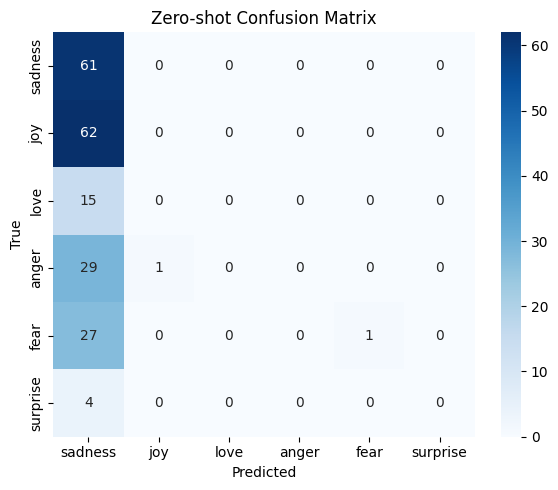

In [ ]:
# ============================================================
# 4. Zero-shot Classifier
# ============================================================
from textwrap import dedent

class ZeroShotClassifier:
    """
    使用 CausalLM + prompt 做 zero-shot 情緒分類。
    不用訓練，只靠自然語言指令。
    """

    def __init__(self, model, tokenizer, labels: List[str]):
        self.model = model
        self.tok = tokenizer
        self.labels = labels

    # def build_prompt(self, text: str) -> str:
    #     """
    #     建一個簡單英文 prompt，請 LLM 選一個情緒。
    #     """
    #     label_str = ", ".join(self.labels)
    #     return (
    #         "You are an emotion classification assistant.\n"
    #         f"Your task is to classify the emotion of the given sentence into one of: {label_str}.\n\n"
    #         f"Sentence: {text}\n\n"
    #         "Answer with only the emotion word."
    #     )

    # @torch.no_grad()
    # def predict_single(self, text: str) -> int:
    #     prompt = self.build_prompt(text)
    #     inputs = self.tok(prompt, return_tensors="pt", truncation=True, max_length=256).to(DEVICE)
    #     outputs = self.model.generate(
    #         **inputs,
    #         max_new_tokens=16,
    #         do_sample=False,  # deterministic，方便 debug
    #     )
    #     ans = self.tok.decode(outputs[0], skip_special_tokens=True).lower()

    #     # 從 LLM 回覆裡找出對應的 emotion label
    #     for i, emo in enumerate(self.labels):
    #         if emo.lower() in ans:
    #             return i
    #     return 0  # fallback: 找不到就當作第一類



    def build_prompt(self, text: str) -> str:
        label_str = ", ".join(self.labels)

        prompt = f"""
                <|system|>
                You are an expert emotion classification model.
                Your task is to read a sentence and output ONLY one emotion from the list:
                {label_str}

                Output format example: anger
                Do NOT explain anything.
                </s>

                <|user|>
                Classify the emotion of this sentence:
                "{text}"
                </s>

                <|assistant|>
                """
        return dedent(prompt).strip()

    @torch.no_grad()
    def predict_single(self, text: str) -> int:
        prompt = self.build_prompt(text)
        inputs = self.tok(prompt, return_tensors="pt", truncation=True, max_length=256).to(DEVICE)
        outputs = self.model.generate(
            **inputs,
            max_new_tokens=16,
            do_sample=False,
            pad_token_id=self.tok.eos_token_id,
        )

        # 🚀 只取新生成內容
        generated = outputs[0][inputs["input_ids"].shape[1]:]
        ans = self.tok.decode(generated, skip_special_tokens=True).strip().lower()

        # 🚀 先做精確比對
        for i, emo in enumerate(self.labels):
            if ans == emo.lower():
                return i

        # 🚀 再 fallback：取最後一個 word 去比
        last_word = ans.split()[-1]
        for i, emo in enumerate(self.labels):
            if last_word == emo.lower():
                return i

        return 0

    def predict_batch(self, texts: List[str]) -> np.ndarray:
        preds = [self.predict_single(t) for t in texts]
        return np.array(preds, dtype=int)

    def evaluate(self, ds, max_samples: int = None) -> Tuple[Dict[str, float], np.ndarray, np.ndarray, np.ndarray]:
        """
        - ds: HF dataset（有 'text'、'label' 欄位）
        - 只跑前 max_samples 筆（避免太慢）
        回傳：
        - metrics: dict
        - y_true: (N,)
        - y_pred: (N,)
        - prob:  (N, num_labels)  ← 這裡我們用 one-hot 模擬
        """
        texts = ds["text"]
        labels = ds["label"]
        if max_samples is not None:
            texts = texts[:max_samples]
            labels = labels[:max_samples]

        y_true = np.array(labels)
        y_pred = self.predict_batch(texts)

        # 基本指標
        basic = compute_basic_metrics(y_true, y_pred)

        # 用 one-hot 當成假機率，這樣還是可以算 AUROC / PR-AUC（雖然比較硬）
        prob = np.zeros((len(y_pred), len(self.labels)), dtype=float)
        for i, pred in enumerate(y_pred):
            prob[i, pred] = 1.0

        prob_metrics = compute_prob_metrics(y_true, prob, num_labels=len(self.labels))

        metrics = {**basic, **prob_metrics}
        return metrics, y_true, y_pred, prob


zero_clf = ZeroShotClassifier(llm_model, llm_tokenizer, EMOTION_LABELS)
zs_metrics, zs_y_true, zs_y_pred, zs_prob = zero_clf.evaluate(
    test_ds,
    max_samples=cfg.max_test_for_prompt,
)
print("Zero-shot metrics:", zs_metrics)
plot_confusion(zs_y_true, zs_y_pred, EMOTION_LABELS, "Zero-shot Confusion Matrix")


串流輸出內容已截斷至最後 5000 行。
tensor([[    1,   529, 29989,  5205, 29989, 29958,    13, 18884,   887,   526,
           385, 17924,   953,  8194, 12965,  1904, 29889,    13, 18884,  2266,
           526,   301, 24025,  6455, 29901,    13,    13, 18884, 28048,   663,
         29901,   376, 29875, 28950,  4459,  3165,  2638,   630, 29908,    13,
          6026,  8194, 29901, 14610,  2264,    13,    13, 29903,   296,   663,
         29901,   376, 29875,   508,   748,   515, 11223,   577,  8171,  6393,
           304,   577,  5625,  9571,  4966,  1319,   925,   515,  1641,  2820,
          4856,  1058,  1559,   267,   322,   338,  3773,  1296, 29908,    13,
          6026,  8194, 29901, 14610,  2264,    13,    13, 29903,   296,   663,
         29901,   376,   573,  1063, 11223,   263,  2217,  6866,  1145,   287,
           301,  2486,   471,   593,  1854,  2020,   393,   471, 29908,    13,
          6026,  8194, 29901, 14610,  2264,    13,    13, 29903,   296,   663,
         29901,   376, 29875,  

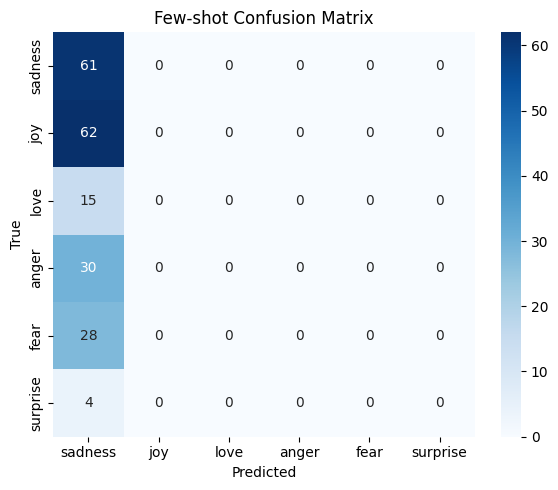

In [ ]:
# ============================================================
# 5. Few-shot Classifier
# ============================================================

class FewShotClassifier:
    """
    Few-shot：在 prompt 裡塞幾個已標註的例子，讓 LLM 學 pattern。
    """

    def __init__(self, model, tokenizer, labels: List[str], support_examples: List[Dict]):
        self.model = model
        self.tok = tokenizer
        self.labels = labels
        self.support_examples = support_examples

    # def build_prompt(self, text: str) -> str:
    #     """
    #     Prompt 包含：
    #     - 說明
    #     - 幾個示範 Sentence + Emotion
    #     - 要分類的新句子
    #     """
    #     label_str = ", ".join(self.labels)
    #     demo_str = ""
    #     for ex in self.support_examples:
    #         demo_str += f"Sentence: {ex['text']}\nEmotion: {ex['label']}\n\n"

    #     return (
    #         "You are an emotion classification assistant.\n"
    #         "Here are some labeled examples:\n\n"
    #         f"{demo_str}"
    #         f"Now classify the emotion of the following sentence into one of: {label_str}.\n\n"
    #         f"Sentence: {text}\n\n"
    #         "Answer with only the emotion word."
    #     )

    # @torch.no_grad()
    # def predict_single(self, text: str) -> int:
    #     prompt = self.build_prompt(text)
    #     inputs = self.tok(prompt, return_tensors="pt", truncation=True, max_length=512).to(DEVICE)
    #     outputs = self.model.generate(
    #         **inputs,
    #         max_new_tokens=16,
    #         do_sample=False,
    #     )
    #     ans = self.tok.decode(outputs[0], skip_special_tokens=True).lower()
    #     for i, emo in enumerate(self.labels):
    #         if emo.lower() in ans:
    #             return i
    #     return 0

    def build_prompt(self, text: str) -> str:
        label_str = ", ".join(self.labels)

        demo = ""
        for ex in self.support_examples:
            demo += f'Sentence: "{ex["text"]}"\nEmotion: {ex["label"]}\n\n'

        prompt = f"""
                <|system|>
                You are an expert emotion classification model.
                Here are labeled examples:

                {demo}

                Now classify the next sentence into one of:
                {label_str}

                Output only one word.
                </s>

                <|user|>
                Sentence: "{text}"
                </s>

                <|assistant|>
                """
        return dedent(prompt).strip()


    @torch.no_grad()
    def predict_single(self, text: str) -> int:
        prompt = self.build_prompt(text)
        inputs = self.tok(prompt, return_tensors="pt", truncation=True, max_length=256).to(DEVICE)
        outputs = self.model.generate(
            **inputs,
            max_new_tokens=16,
            do_sample=False,
            pad_token_id=self.tok.eos_token_id,
        )

        # 🚀 只取新生成內容
        generated = outputs[0][inputs["input_ids"].shape[1]:]
        ans = self.tok.decode(generated, skip_special_tokens=True).strip().lower()

        # print(prompt)
        # print(inputs)
        # print(outputs)
        # print(ans)
        # print()
        # print()

        # 🚀 先做精確比對
        for i, emo in enumerate(self.labels):
            if ans == emo.lower():
                return i

        # 🚀 再 fallback：取最後一個 word 去比
        last_word = ans.split()[-1]
        for i, emo in enumerate(self.labels):
            if last_word == emo.lower():
                return i

        return 0

    def predict_batch(self, texts: List[str]) -> np.ndarray:
        preds = [self.predict_single(t) for t in texts]
        return np.array(preds, dtype=int)

    def evaluate(self, ds, max_samples: int = None) -> Tuple[Dict[str, float], np.ndarray, np.ndarray, np.ndarray]:
        texts = ds["text"]
        labels = ds["label"]
        if max_samples is not None:
            texts = texts[:max_samples]
            labels = labels[:max_samples]

        y_true = np.array(labels)
        y_pred = self.predict_batch(texts)

        basic = compute_basic_metrics(y_true, y_pred)

        # 同樣用 one-hot 當 pseudo-prob
        prob = np.zeros((len(y_pred), len(self.labels)), dtype=float)
        for i, pred in enumerate(y_pred):
            prob[i, pred] = 1.0

        prob_metrics = compute_prob_metrics(y_true, prob, num_labels=len(self.labels))
        metrics = {**basic, **prob_metrics}
        return metrics, y_true, y_pred, prob


# 建 few-shot 用的 support examples：每個 label 抽幾句
def build_support_examples(train_ds, label_names: List[str], k_per_label: int = 3) -> List[Dict]:
    """
    從 training set 裡，每個情緒抓 k 個例子當 demo。
    """
    by_label = {i: [] for i in range(len(label_names))}
    for ex in train_ds:
        lid = ex["label"]
        if len(by_label[lid]) < k_per_label:
            by_label[lid].append(ex["text"])

        if all(len(v) >= k_per_label for v in by_label.values()):
            break

    support = []
    for lid, texts in by_label.items():
        for t in texts:
            support.append({"text": t, "label": label_names[lid]})
    return support


support_examples = build_support_examples(train_ds, EMOTION_LABELS, k_per_label=3)
print("Number of few-shot examples:", len(support_examples))

few_clf = FewShotClassifier(llm_model, llm_tokenizer, EMOTION_LABELS, support_examples)
fs_metrics, fs_y_true, fs_y_pred, fs_prob = few_clf.evaluate(
    test_ds,
    max_samples=cfg.max_test_for_prompt,
)
print("Few-shot metrics:", fs_metrics)
plot_confusion(fs_y_true, fs_y_pred, EMOTION_LABELS, "Few-shot Confusion Matrix")


=== LoRA Fine-tune (DeBERTa) ===


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA target modules: ['query_proj', 'key_proj', 'value_proj', 'output_proj', 'dense']
trainable params: 5,362,182 || all params: 189,788,940 || trainable%: 2.8253


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/tmp/ipython-input-253319427.py:118: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  self.trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
200,1.655500,1.587303,0.352000,0.086785,0.183290
400,1.374600,1.374278,0.511500,0.215372,0.412150
600,1.151000,1.140438,0.590000,0.242430,0.463273
800,1.081600,1.038854,0.596000,0.245175,0.468559
1000,1.021400,0.863559,0.679000,0.403928,0.593550
1200,0.816200,0.731347,0.752000,0.519518,0.703425
1400,0.724000,0.649210,0.782500,0.618525,0.751830
1600,0.590700,0.574457,0.812500,0.696560,0.801369
1800,0.591500,0.518054,0.835000,0.743901,0.820497
2000,0.520200,0.437051,0.860000,0.788083,0.856577


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

LoRA metrics: {'accuracy': 0.904, 'f1_macro': 0.8565270537655554, 'f1_weighted': 0.9048160215264317, 'auroc': np.float64(0.9873475958372911), 'pr_auc': np.float64(0.9230207129581273)}


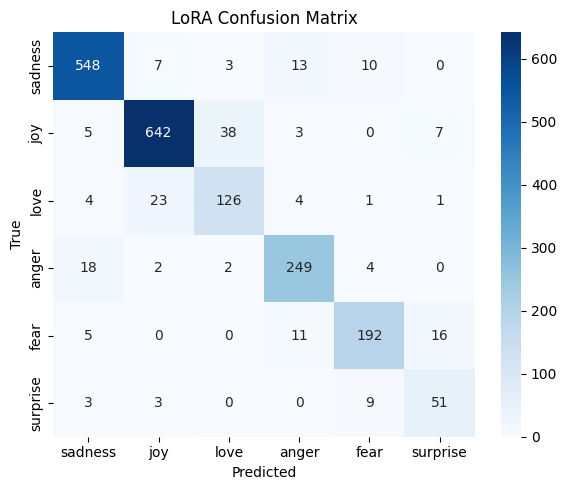

In [ ]:
# ============================================================
# 6. LoRA + DeBERTa Emotion Classifier
# ============================================================

class LoRAEmotionClassifier:
    """
    使用 AutoModelForSequenceClassification + LoRA 做情緒分類微調。
    """

    def __init__(self, cfg: Config, label_names: List[str]):
        self.cfg = cfg
        self.label_names = label_names

        # 載入 tokenizer
        self.tok = AutoTokenizer.from_pretrained(cfg.seqcls_model_name)
        if self.tok.pad_token is None:
            self.tok.pad_token = self.tok.eos_token

        # base config
        base_config = AutoConfig.from_pretrained(
            cfg.seqcls_model_name,
            num_labels=len(label_names),
            problem_type="single_label_classification",
        )

        # base model
        base_model = AutoModelForSequenceClassification.from_pretrained(
            cfg.seqcls_model_name,
            config=base_config,
        )

        target_modules = list(self.cfg.lora_target_modules)
        if not target_modules:
            target_modules = list(cfg.lora_target_modules)

        print("LoRA target modules:", target_modules)

        lora_cfg = LoraConfig(
            r=cfg.lora_r,
            lora_alpha=cfg.lora_alpha,
            lora_dropout=cfg.lora_dropout,
            target_modules=target_modules,
            task_type="SEQ_CLS",
            bias="none",
        )

        self.model = get_peft_model(base_model, lora_cfg)
        self.model.print_trainable_parameters()

    # ---------- Dataset Preprocess ----------
    def preprocess(self, examples):
        enc = self.tok(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=self.cfg.max_length,
        )
        enc["labels"] = examples["label"]
        return enc

    def prepare_dataset(self, train_ds, val_ds):
        remove_cols = [c for c in train_ds.column_names if c not in ["text", "label"]]

        train = train_ds.map(
            self.preprocess,
            batched=True,
            remove_columns=remove_cols,
        )
        val = val_ds.map(
            self.preprocess,
            batched=True,
            remove_columns=remove_cols,
        )
        return train, val

    # ---------- Training ----------
    def train(self, train_ds, val_ds):
        train_proc, val_proc = self.prepare_dataset(train_ds, val_ds)

        # training_args = TrainingArguments(
        #     output_dir=self.cfg.output_dir,
        #     per_device_train_batch_size=self.cfg.train_batch_size,
        #     per_device_eval_batch_size=self.cfg.eval_batch_size,
        #     num_train_epochs=self.cfg.num_epochs,
        #     learning_rate=self.cfg.learning_rate,
        #     warmup_ratio=self.cfg.warmup_ratio,
        #     logging_steps=100,
        #     evaluation_strategy="steps",
        #     eval_steps=200,
        #     save_steps=200,
        #     save_total_limit=1,
        #     load_best_model_at_end=True,
        #     report_to="none",
        # )
        training_args = TrainingArguments(
            output_dir=self.cfg.output_dir,
            per_device_train_batch_size=self.cfg.train_batch_size,
            per_device_eval_batch_size=self.cfg.eval_batch_size,
            num_train_epochs=self.cfg.num_epochs,
            learning_rate=self.cfg.learning_rate,
            warmup_ratio=self.cfg.warmup_ratio,
            weight_decay=self.cfg.weight_decay,
            logging_steps=100,
            eval_strategy="steps",     # 新版名稱
            eval_steps=200,
            save_strategy="steps",     # 同時修正 save
            save_steps=200,
            save_total_limit=1,
            load_best_model_at_end=True,
            report_to="none",
        )

        def compute_metrics_for_trainer(eval_pred):
            logits, labels = eval_pred
            preds = np.argmax(logits, axis=-1)
            return compute_basic_metrics(labels, preds)

        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_proc,
            eval_dataset=val_proc,
            tokenizer=self.tok,
            compute_metrics=compute_metrics_for_trainer,
        )

        self.trainer.train()

    # ---------- Predict on test ----------
    def predict(self, ds):
        """
        回傳：
        - y_true: (N,)
        - y_pred: (N,)
        - prob:   (N, num_labels)
        """
        test_proc = ds.map(
            self.preprocess,
            batched=True,
            remove_columns=ds.column_names,
        )
        outputs = self.trainer.predict(test_proc)
        logits = outputs.predictions
        prob = torch.softmax(torch.tensor(logits), dim=-1).numpy()
        y_pred = prob.argmax(axis=-1)
        y_true = np.array(ds["label"])
        return y_true, y_pred, prob


print("=== LoRA Fine-tune (DeBERTa) ===")
lora_clf = LoRAEmotionClassifier(cfg, EMOTION_LABELS)
lora_clf.train(train_ds, val_ds)
lora_y_true, lora_y_pred, lora_prob = lora_clf.predict(test_ds)

lora_basic = compute_basic_metrics(lora_y_true, lora_y_pred)
lora_prob_metrics = compute_prob_metrics(lora_y_true, lora_prob, num_labels=NUM_LABELS)
lora_metrics = {**lora_basic, **lora_prob_metrics}
print("LoRA metrics:", lora_metrics)
plot_confusion(lora_y_true, lora_y_pred, EMOTION_LABELS, "LoRA Confusion Matrix")


In [ ]:
# ============================================================
# 7. Emotion → Risk & Visualization
# ============================================================

def emotions_to_risk_levels(pred_ids: np.ndarray, risk_map: Dict[int, int]) -> np.ndarray:
    """
    將情緒類別（0~5）映射成 0/1/2 風險等級。
    """
    return np.array([risk_map[int(i)] for i in pred_ids], dtype=int)


def plot_risk_series(risk_levels: np.ndarray, title: str):
    """
    簡單的風險走勢圖：x 軸是樣本 index，y 軸是 risk level (0/1/2)。
    """
    plt.figure(figsize=(10, 3))
    plt.plot(risk_levels, linewidth=1)
    plt.yticks([0, 1, 2], ["Low", "Mid", "High"])
    plt.title(title)
    plt.xlabel("Sample index")
    plt.ylabel("Risk level")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def compute_high_risk_prob_from_prob(prob: np.ndarray, label_names: List[str]) -> np.ndarray:
    """
    從多類別概率 prob (N, num_labels) 中，找出 sadness 的機率當作「高風險機率」。
    """
    sadness_idx = label_names.index("sadness") if "sadness" in label_names else None
    if sadness_idx is None:
        # 若剛好沒有 sadness label，就用風險 map 中所有 "high risk" label 的總和
        high_ids = [i for i, r in RISK_MAP.items() if r == 2]
        return prob[:, high_ids].sum(axis=-1)
    else:
        return prob[:, sadness_idx]


def rolling_mean(x: np.ndarray, window: int) -> np.ndarray:
    """
    計算簡單 rolling mean，前期不足 window 時，就用目前為止平均。
    """
    out = np.zeros_like(x, dtype=float)
    for i in range(len(x)):
        s = max(0, i - window + 1)
        out[i] = x[s : i + 1].mean()
    return out


def plot_high_risk_heatmap(high_risk_prob: np.ndarray, block_size: int = 50, title: str = "High-risk Heatmap"):
    """
    把高風險機率切成多個 block，用 2D heatmap 顯示濃度變化。
    """
    n = len(high_risk_prob)
    num_blocks = int(np.ceil(n / block_size))
    pad_len = num_blocks * block_size - n
    padded = np.pad(high_risk_prob, (0, pad_len), constant_values=np.nan)
    mat = padded.reshape(num_blocks, block_size)

    plt.figure(figsize=(10, 4))
    sns.heatmap(mat, cmap="Reds", vmin=0, vmax=1)
    plt.title(f"{title} (block_size={block_size})")
    plt.xlabel("Time within block")
    plt.ylabel("Block index")
    plt.tight_layout()
    plt.show()


===== Metrics Comparison =====
Zero-shot: {'accuracy': 0.305, 'f1_macro': 0.07790549169859515, 'f1_weighted': 0.14256704980842913, 'auroc': np.float64(0.5), 'pr_auc': np.float64(0.16666666666666666)}
Few-shot : {'accuracy': 0.305, 'f1_macro': 0.07790549169859515, 'f1_weighted': 0.14256704980842913, 'auroc': np.float64(0.5), 'pr_auc': np.float64(0.16666666666666666)}
LoRA     : {'accuracy': 0.904, 'f1_macro': 0.8565270537655554, 'f1_weighted': 0.9048160215264317, 'auroc': np.float64(0.9873475958372911), 'pr_auc': np.float64(0.9230207129581273)}


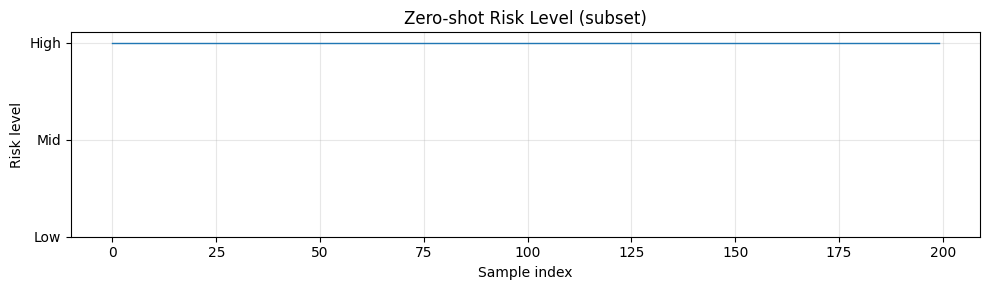

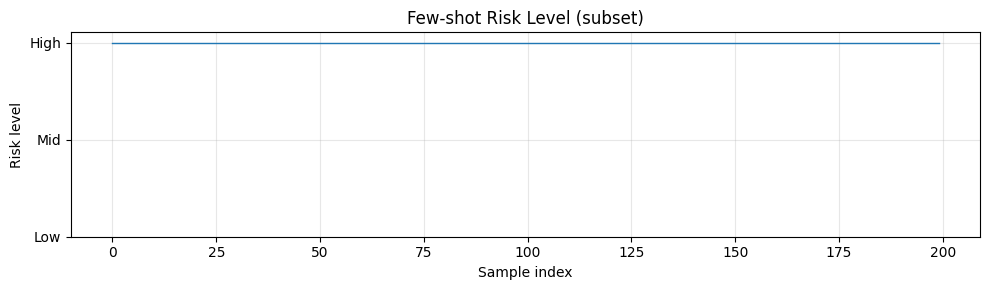

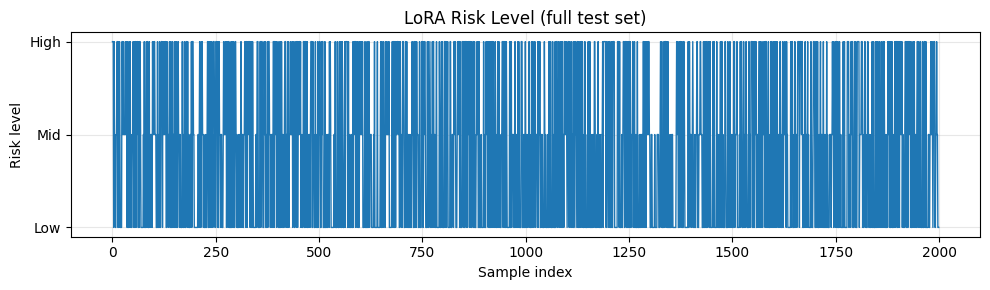

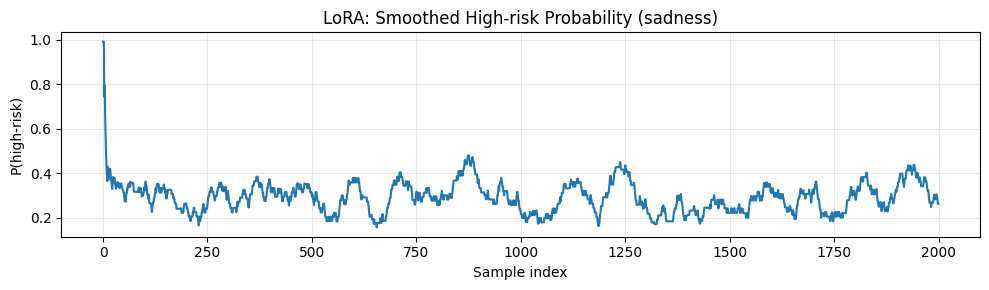

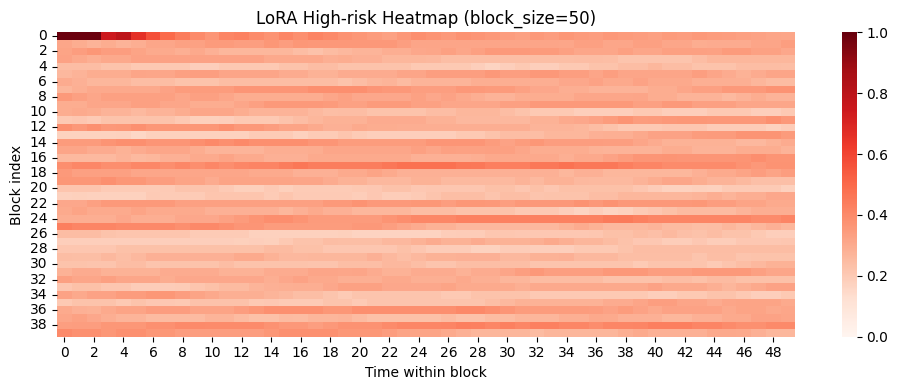

In [ ]:
# ============================================================
# 8. Compare All Methods & Risk Visualization
# ============================================================

print("===== Metrics Comparison =====")
print("Zero-shot:", zs_metrics)
print("Few-shot :", fs_metrics)
print("LoRA     :", lora_metrics)

# Zero-shot risk（用 pseudo prob）
zs_risk = emotions_to_risk_levels(zs_y_pred, RISK_MAP)
plot_risk_series(zs_risk, "Zero-shot Risk Level (subset)")

# Few-shot risk
fs_risk = emotions_to_risk_levels(fs_y_pred, RISK_MAP)
plot_risk_series(fs_risk, "Few-shot Risk Level (subset)")

# LoRA risk + 高風險機率
lora_risk = emotions_to_risk_levels(lora_y_pred, RISK_MAP)
plot_risk_series(lora_risk, "LoRA Risk Level (full test set)")

high_risk_prob = compute_high_risk_prob_from_prob(lora_prob, EMOTION_LABELS)
high_risk_prob_smooth = rolling_mean(high_risk_prob, window=50)

plt.figure(figsize=(10, 3))
plt.plot(high_risk_prob_smooth)
plt.title("LoRA: Smoothed High-risk Probability (sadness)")
plt.xlabel("Sample index")
plt.ylabel("P(high-risk)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plot_high_risk_heatmap(high_risk_prob_smooth, block_size=50, title="LoRA High-risk Heatmap")
